<a href="https://colab.research.google.com/github/LuisFelipeOrtolan/QuarentenaDados-Alura/blob/master/Aulas04e05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from string import ascii_letters
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Definindo o modo de impressão do pandas

In [0]:
%precision %.2f
pd.options.display.float_format = '{:,.2f}'.format

##Aula 4

Obtendo o dataframe

In [3]:
df = pd.read_csv('https://github.com/guilhermesilveira/enem-2018/blob/master/MICRODADOS_ENEM_2018_SAMPLE_43278.csv?raw=true')
df.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,...,TX_RESPOSTAS_MT,TP_LINGUA,TX_GABARITO_CN,TX_GABARITO_CH,TX_GABARITO_LC,TX_GABARITO_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
0,180009327796,2018,2112209,Timon,21,MA,34.00,M,1.00,1,1,"2,207,702.00",Parnaíba,22.00,PI,1,5,1,3.00,0,nan,nan,NaN,nan,NaN,nan,nan,nan,0,0,0,1,0,0,0,0,0,0,0,0,...,NaN,1,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,B,B,B,B,4,C,A,B,C,A,B,B,A,B,A,B,A,A,B,A,A,C,A,B,B,A,A
1,180012890374,2018,3557105,Votuporanga,35,SP,14.00,M,0.00,1,1,"3,557,105.00",Votuporanga,35.00,SP,4,0,1,nan,0,nan,nan,NaN,nan,NaN,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,0,0,...,ADDEDEEBCAADDEDEBECCBAECECEDBAADEABAECDADECDC,0,BCACEEBBBDACEDECAADDDABDBCCACDCBCEDEDABEBEAEA,CDECAABBDDECBEEDBEBBEBEDEEEBCEAEECECCDBDDCACD,CBEDBBBDCBECADBBBECBEAECABDADACDBABCECBBEDADAB...,ADAEDABBCAADBEXEBBDEEADCCCCDACEDDABCBCAAEBBDD,1.00,160.00,120.00,120.00,160.00,120.00,680.00,F,F,A,D,4,N,A,D,D,C,A,B,A,B,A,B,A,A,C,A,B,E,B,D,B,D,D
2,180008223824,2018,2506301,Guarabira,25,PB,20.00,F,0.00,2,1,"2,506,301.00",Guarabira,25.00,PB,1,3,1,1.00,0,nan,nan,NaN,nan,NaN,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,0,0,...,ABCBEECAABDDADCACAAAABDDEDACAEEECCDCEBBABBECB,1,BDDEDBCACEBCCACDCDDAECAADBDBCEEAEAABEBEBBACED,CACDDBDDECCEDEEEBCEAEECBBEBEDBEDECBEBDCAABCDE,BBDECBBCDBCECBABDBEDACDDBBBEADECACEDBEBABCBEAE...,ACEADCEBBDADAAEBBDDEDABADBEXCCCDBCAEEACBCDDAB,1.00,120.00,120.00,120.00,120.00,120.00,600.00,E,E,B,B,5,B,A,B,D,A,A,B,A,A,A,B,A,A,B,A,A,D,A,B,B,A,E
3,180007859645,2018,3534807,Ouro Verde,35,SP,17.00,F,0.00,2,1,"3,514,403.00",Dracena,35.00,SP,2,0,1,1.00,0,nan,nan,NaN,nan,NaN,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,0,0,...,DEBEBEABDABECACDDDECBBDDBCBBCABDAACCECBABDCDA,0,ACEDEAEAEBECAADABBDBCEDEDDCDDABCCACBCACEBDEBB,ECCBBEBEDBEDBDDAEECDECBECACDEDEECDECAABBDEBCE,BCDEBDBCBBACDCBEAECBABADBBECECBDBBEABDADACEDEC...,EBBDEECCCDACEADCBCAAEBBCBCADAEDABADDADDABDBEX,1.00,100.00,120.00,100.00,80.00,0.00,400.00,B,D,C,C,7,F,A,B,D,B,A,B,B,B,A,A,A,A,B,A,A,E,A,A,A,B,A
4,180013499517,2018,3523107,Itaquaquecetuba,35,SP,19.00,M,0.00,3,1,"3,550,308.00",São Paulo,35.00,SP,1,2,1,1.00,0,nan,nan,NaN,nan,NaN,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,0,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,F,F,B,D,5,E,A,B,C,B,A,B,A,B,A,A,A,A,B,A,A,D,B,B,B,A,A


O primeiro desafio é substituir as notas das pessoas que não estiveram presentes em uma ou mais provas para alguma nota, já que os valores estão preenchidos com NaN. O número escolhido foi o 0. Corrigiremos as notas com os status 0 ou 2, isso porque o primeiro significa que faltou e o segundo que foi desclassificado.

In [0]:
notas_corrigidas = df.copy()

notas_corrigidas.loc[notas_corrigidas.TP_PRESENCA_CN.isin([0,2]), 'NU_NOTA_CN'] = 0
notas_corrigidas.loc[notas_corrigidas.TP_PRESENCA_CH.isin([0,2]), 'NU_NOTA_CH'] = 0
notas_corrigidas.loc[notas_corrigidas.TP_PRESENCA_LC.isin([0,2]), 'NU_NOTA_LC'] = 0
notas_corrigidas.loc[notas_corrigidas.TP_PRESENCA_MT.isin([0,2]), 'NU_NOTA_MT'] = 0

Agora, destes dados vamos tentar obter uma matriz de correlações entre as notas.

In [5]:
colunas_de_notas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
dados_notas = notas_corrigidas[colunas_de_notas].dropna()
dados_notas.columns = ['ciencias_naturais', 'ciencias_humanas', 'linguagem_codigo', 'matematica', 'redacao']

correlacao_notas = dados_notas.corr()
correlacao_notas

,ciencias_naturais,ciencias_humanas,linguagem_codigo,matematica,redacao
ciencias_naturais,1.00,0.39,0.39,0.86,0.38
ciencias_humanas,0.39,1.00,0.70,0.40,0.50
linguagem_codigo,0.39,0.70,1.00,0.42,0.56
matematica,0.86,0.40,0.42,1.00,0.40
redacao,0.38,0.50,0.56,0.40,1.00


Fazendo uma análise, percebemos que existe uma relação entre as provas do mesmo dia. Ciências Naturais e Matemática, que são as provas do segundo dia do ENEM, possuem 86% de correlação, e Ciências Humanas e Linguagens e Código, que sãp as provas do primeiro dia do ENEM, tem uma relação de 70%.

Além disso, observamos que a maior correlação de redação é com Linguagens e Códigos, o que faz sentido, já que as duas tratam relativamente de um mesmo domínio.

O próximo desafio era o de plotar uma matriz de correlação.

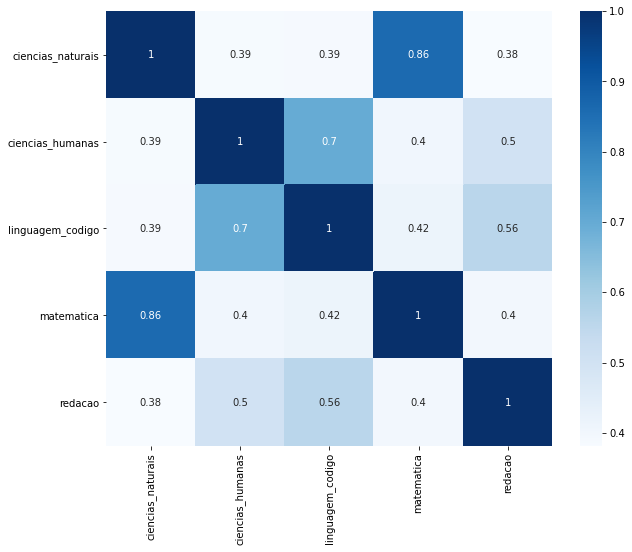

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlacao_notas, annot=True, cmap='Blues')
plt.show()


Outro tipo de gráfico interessante para a Análise de Dados é o pairplot. Vamos começar com um pairplot dos mesmos dados da matriz de correlação:

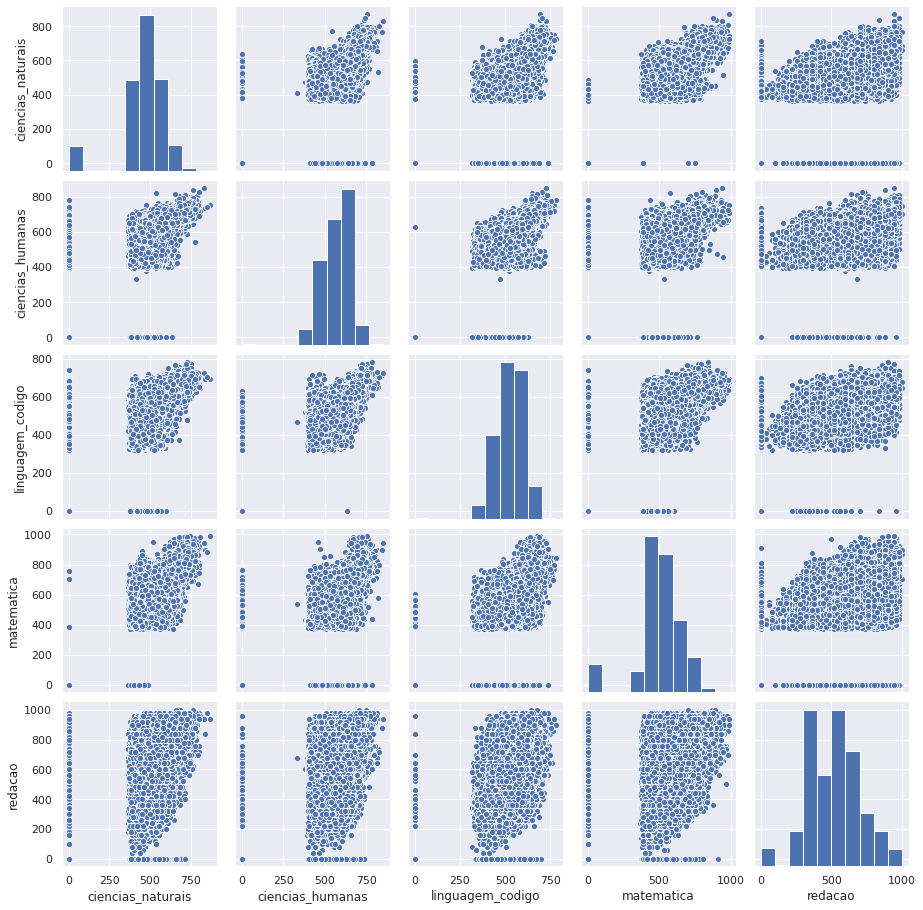

In [7]:
sns.set()
sns.pairplot(dados_notas)
plt.show()

O próximo desafio era fazer um pairplot, mas ao invés de usar as notas do ENEM(que usam o Teorema de Resposta ao Item para calcular uma nota a partir do resultado do aluno) usar a quantidade de questões que cada aluno acertou.

In [0]:
def conta_acertos(aluno, materia):
  soma = 0
  respostas = aluno.get(f'TX_RESPOSTAS_{materia}')
  gabarito = aluno.get(f'TX_GABARITO_{materia}')

  if (type(respostas) != str or type(gabarito) != str):
    return 0

  for a,b in zip(respostas,gabarito):
    if a==b:
      soma = soma + 1 

  return soma

In [0]:
notas_corrigidas['acertos_CN'] = notas_corrigidas.apply(conta_acertos, axis = 1, materia = 'CN')
notas_corrigidas['acertos_CH'] = notas_corrigidas.apply(conta_acertos, axis = 1, materia = 'CH')
notas_corrigidas['acertos_LC'] = notas_corrigidas.apply(conta_acertos, axis = 1, materia = 'LC')
notas_corrigidas['acertos_MT'] = notas_corrigidas.apply(conta_acertos, axis = 1, materia = 'MT')

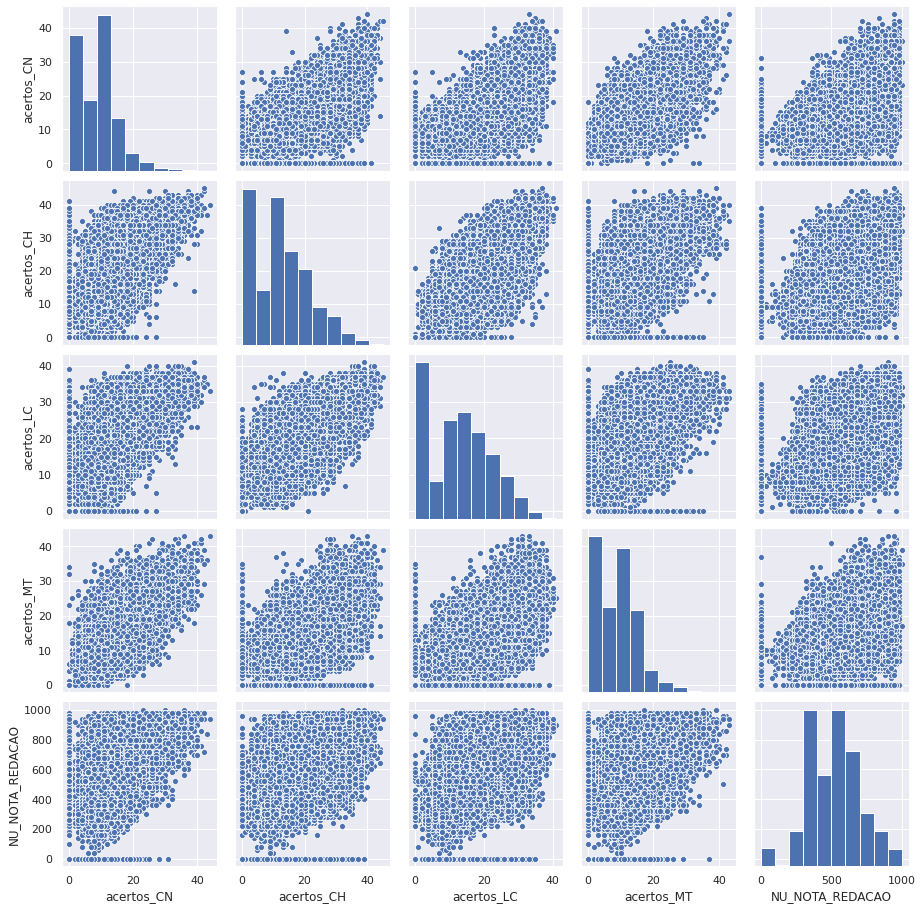

In [10]:
colunas_notas_absolutas = ['acertos_CN','acertos_CH', 'acertos_LC', 'acertos_MT','NU_NOTA_REDACAO'] 
notas_absolutas = notas_corrigidas[colunas_notas_absolutas]

sns.set()
sns.pairplot(notas_absolutas)
plt.show()

Agora, o desafio é remover todos os candidatos que têm 0 em alguma das notas, para isso será usada a dica de um dos professores do curso de substituir as notas zero por NaN e depois remover os NaNs.

In [0]:
notas_corrigidas_sem0 = notas_corrigidas.copy()

notas_corrigidas_sem0['acertos_CN'] = notas_corrigidas_sem0['acertos_CN'].replace(0, np.nan)
notas_corrigidas_sem0['acertos_CH'] = notas_corrigidas_sem0['acertos_CH'].replace(0, np.nan)
notas_corrigidas_sem0['acertos_LC'] = notas_corrigidas_sem0['acertos_LC'].replace(0, np.nan)
notas_corrigidas_sem0['acertos_MT'] = notas_corrigidas_sem0['acertos_MT'].replace(0, np.nan)

In [0]:
notas_corrigidas_sem0 = notas_corrigidas_sem0.dropna(subset = ['acertos_CN', 'acertos_CH', 'acertos_LC', 'acertos_MT'])

O penúltimo desafio é fazer uma análise das questões de alguma prova. Isto é, analisar as questões com mais acertos, mais erros.

In [0]:
def corrige_prova(aluno, materia):
  respostas = aluno.get(f'TX_RESPOSTAS_{materia}')
  gabarito = aluno.get(f'TX_GABARITO_{materia}')

  # Cria uma série com 1 se a questão for acertada pelo aluno e 0 caso contrário.
  acertos = pd.Series([int(a==b) for a,b in zip(respostas,gabarito)])
  return acertos

In [14]:
# Obtendo uma prova qualquer.

prova454 = notas_corrigidas.query("CO_PROVA_CH == 454")

# Criando uma matriz com os acertos e erros de cada questão por todos os alunos.
acertos = prova454.apply(corrige_prova, axis = 1, materia = 'CH')
acertos

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
1,0,1,1,1,1,1,0,1,0,0,1,1,1,1,1,1,1,1,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,1,1,1,1,0,1,0,0,1,1,1
8,0,0,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0
9,0,0,0,1,1,0,1,1,0,1,1,0,1,1,1,1,0,1,1,1,0,0,1,0,0,1,0,0,1,1,0,0,1,1,1,0,0,1,1,1,0,0,1,1,0
12,1,0,0,1,1,0,1,0,1,0,1,1,1,0,0,1,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,1,0,0,1,0,0,1,1,1,0,0,0,0,1
21,0,0,1,0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,1,1,0,0,0,1,1,0,1,1,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137830,0,1,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
137831,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
137835,1,0,0,1,1,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
137840,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0


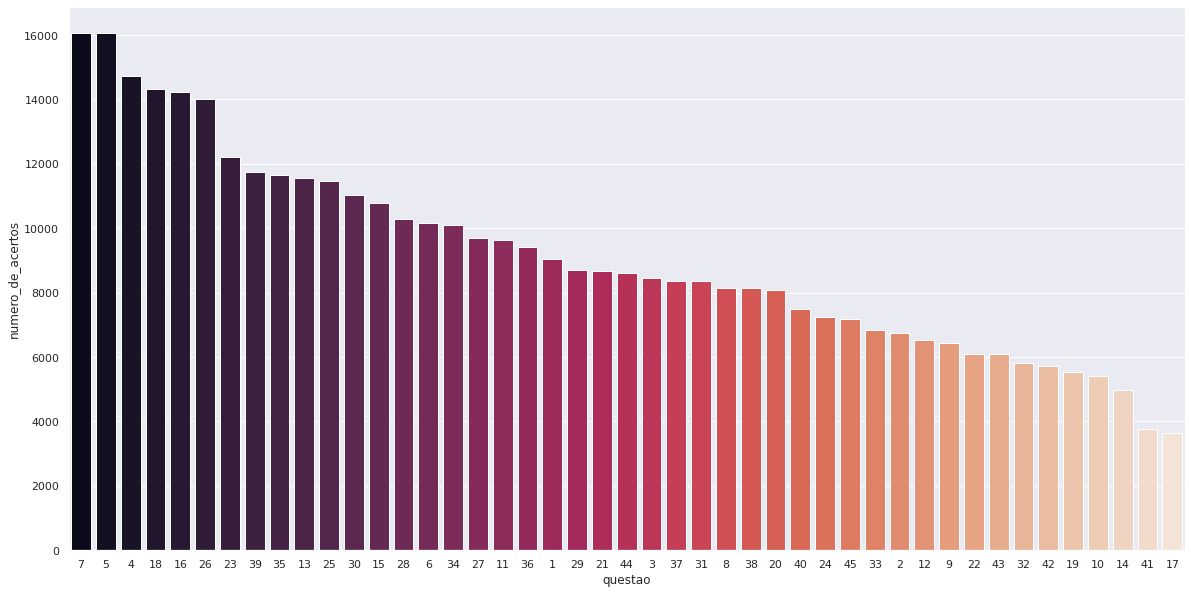

In [15]:
acertos_por_questao = pd.DataFrame(acertos.sum())
acertos_por_questao.reset_index(inplace=True)
acertos_por_questao.columns = ['questao', 'numero_de_acertos']
acertos_por_questao = acertos_por_questao.sort_values(['numero_de_acertos'], ascending = False).reset_index(drop=True)

# Correção para que as questões comecem em 1 e não em 0.
acertos_por_questao['questao'] = acertos_por_questao['questao'] + 1

plt.figure(figsize=(20,10))
sns.barplot(x='questao', y='numero_de_acertos', data = acertos_por_questao, order = acertos_por_questao['questao'], palette="rocket")
plt.show()

Nessa prova de Ciências Humanas, a questão com mais acertos foi a questão 07, perto de 16 mil acertos, enquanto a questão menos acertada foi a número 17. Observa-se que há uma diferença muito pequena entre as duas quesões mais acertadas neste sample assim como nas duas mais erradas. Outro dado interessante é o fato de depois de ambas as duas questões haver uma diferença significante, tanto na terceira mais acertada como na terceira menos. 

## Aula 5

Iremos realizar um primeiro modelo de predição. O objetivo será usar das notas de Matemática, Redação, Ciências Humanas e Cieências da Natureza para prever a nota de Linguagens e Código. Em uma primeira etapa, vamos separar os dados que iremos usar:

In [0]:
x = dados_notas[['ciencias_naturais', 'ciencias_humanas','matematica','redacao']]
y = dados_notas['linguagem_codigo']

Agora precisamos separar os dados que serão usados para treinar o modelo e dados que serão usados para testes. Para que o processo seja repetível, iremos usar uma seed do NumPy.

In [0]:
np.random.seed(30284)

x_treino, x_teste, y_treino, y_teste = train_test_split(x,y)

Com os dados separados, vamos usar a Regressão para tentar prever esses dados. Primeiro, usaremos a linear.

In [18]:
modelo = LinearSVR(C = 2, max_iter = 1000)
modelo.fit(x_treino, y_treino)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=2, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

Com o modelo ajustado aos dados de treino, faremos as predições com os dados que não foram usados ainda

In [19]:
predicoes = modelo.predict(x_teste)

data_predicoes = {'previsao':predicoes, 'valor_real':y_teste }
predicoes_df = pd.DataFrame(data = data_predicoes)
predicoes_df['diferenca'] = predicoes_df['valor_real'] - predicoes_df['previsao']
predicoes_df.head()

,previsao,valor_real,diferenca
103941,603.42,584.60,-18.82
130463,472.87,479.00,6.13
104699,488.28,399.10,-89.18
130904,458.70,453.00,-5.70
134997,581.31,597.60,16.29


Agora será plotado um gráfico para ver como as previsões foram relacionadas as notas reais. Quanto mais próximo de uma reta em que os valores do eixo x são iguais aos do eixo y, melhor:

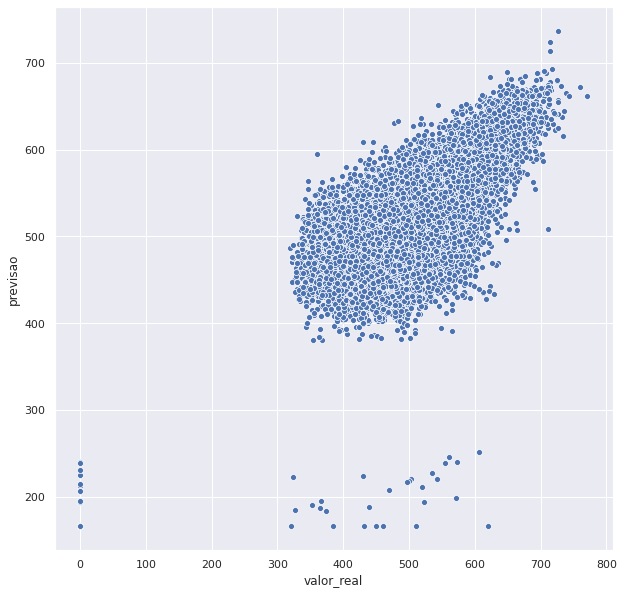

In [20]:
plt.figure(figsize = (10,10))
sns.scatterplot(x=predicoes_df.valor_real, y=predicoes_df.previsao)
plt.show()

Outro gráfico interessante é para observar é o gráfico da nota por quanto a previsão errou. Será interessante para observar se o erro é mais presente em alguma faixa de notas ou não.

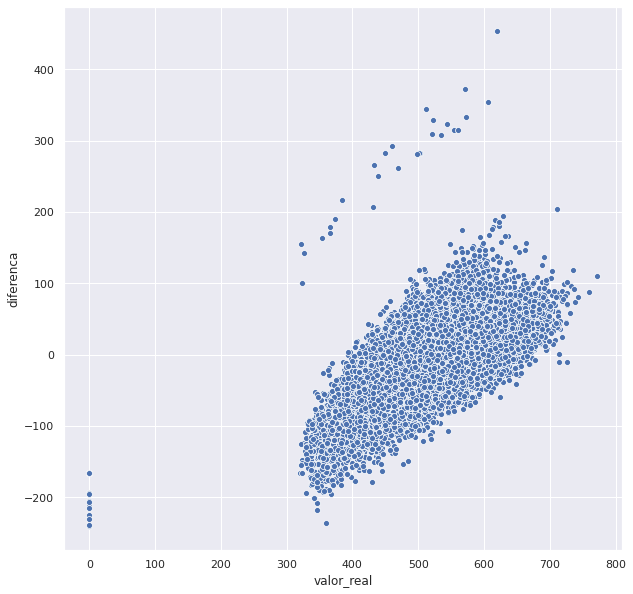

In [21]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=predicoes_df.valor_real, y=predicoes_df.diferenca)
plt.show()

É possível que observar que na faixa entre 300 e 400, a nota geralmente era prevista menor do que de fato foi, enquanto quando a nota foi entre 700 e 800, geralmente era prevista maior do que ela de fato foi.

Um outro modelo de Regressor é o de Árvores de Decisão. Este será usado agora para novas predições

In [22]:
modelo_arvore = DecisionTreeRegressor()
modelo_arvore.fit(x_treino, y_treino)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Depois de treinar o modelo, vamos fazer suas predições

In [23]:
predicoes_arvore = modelo_arvore.predict(x_teste)

data_predicoes_arvore = {'previsao':predicoes_arvore, 'valor_real':y_teste }
predicoes_arvore_df = pd.DataFrame(data = data_predicoes_arvore)
predicoes_arvore_df['diferenca'] = predicoes_arvore_df['valor_real'] - predicoes_arvore_df['previsao']
predicoes_arvore_df.head()

,previsao,valor_real,diferenca
103941,601.50,584.60,-16.90
130463,367.80,479.00,111.20
104699,412.60,399.10,-13.50
130904,432.80,453.00,20.20
134997,650.40,597.60,-52.80


Assim como foi feito na Regressão Linear, será plotado o gráfico dos valores reais pelos valores preditos pela Regressão:

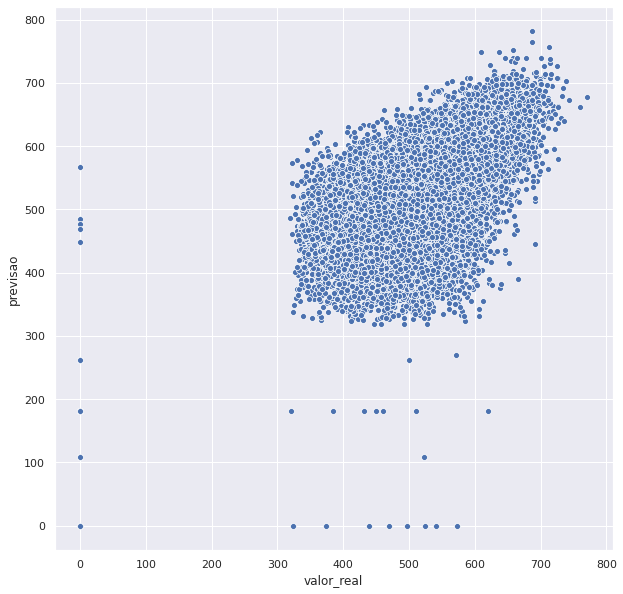

In [24]:
plt.figure(figsize = (10,10))
sns.scatterplot(x=predicoes_arvore_df.valor_real, y=predicoes_arvore_df.previsao)
plt.show()

Agora, vamos plotar os valores previstos e os valores reais, um em cima do outro, para podermos comparar.

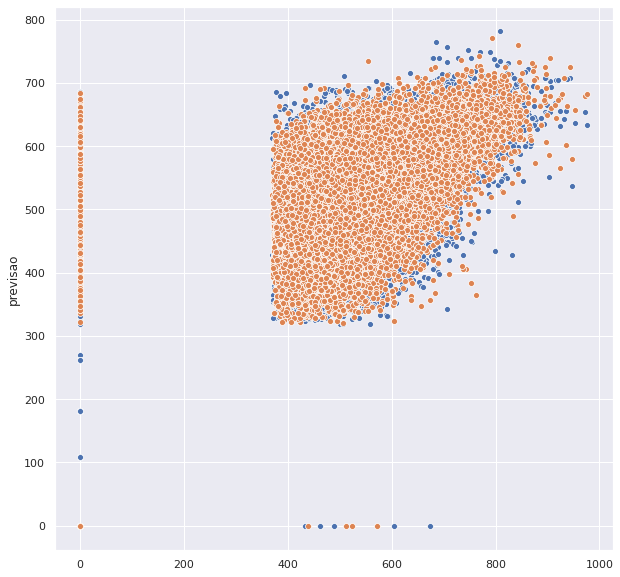

In [25]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=x_teste['matematica'].values, y=predicoes_arvore_df.previsao)
sns.scatterplot(x=x_teste['matematica'].values, y=y_teste.values)
plt.show()

É possível perceber que os valores estão concentrados em uma mesma área, indicando que as predições podem não estar tão distantes dos valores reais. Entretanto, para se ter uma ideia melhor da confiabilidade dessas previsões, vamos calcular o erro quadrático médio dos Regressores. Quanto menor for esses dados, melhor é o Regressor.

In [26]:
## Erro quadrático médio do Regressor Linear
mean_squared_error(y_teste, predicoes_df.previsao)

2475.05

In [27]:
## Erro quadrático médio do Regressor 
mean_squared_error(y_teste, predicoes_arvore_df.previsao)

4306.17

Para determinar o quão bom/mal são os nossos Regressores, é interessante comparar com o Regressor Dummy, e observar quão melhor/pior é que este.

In [28]:
modelo_dummy = DummyRegressor()
modelo_dummy.fit(x_treino,y_treino)
dummy_predicoes = modelo_dummy.predict(x_teste)

mean_squared_error(y_teste, dummy_predicoes)

5342.00

Um dos desafios era usar para a entrada do regressor a média das quatro notas. Para isso, primeiro será calculado a média de cada candidato

In [0]:
media_notas = x_teste.mean(axis = 1)

data_medias = {'media1':media_notas, 'media2':media_notas, 'media3':media_notas, 'media4':media_notas}
media_notas_df = pd.DataFrame(data = data_medias)

In [0]:
predicoes_media = modelo.predict(media_notas_df)
predicoes_media_arvore = modelo_arvore.predict(media_notas_df)

Agora vamos ver o resultado dessas predições, primeiro com a Regressão Linear

In [31]:
mean_squared_error(y_teste, predicoes_media)

4582.00

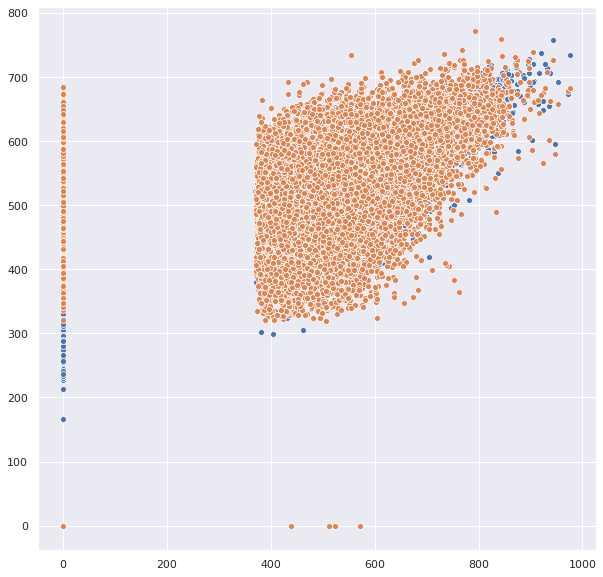

In [32]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=x_teste['matematica'].values, y=predicoes_media)
sns.scatterplot(x=x_teste['matematica'].values, y=y_teste.values)
plt.show()

E agora com a Regressão com Árvore de Decisão

In [33]:
mean_squared_error(y_teste, predicoes_media_arvore)

5508.87

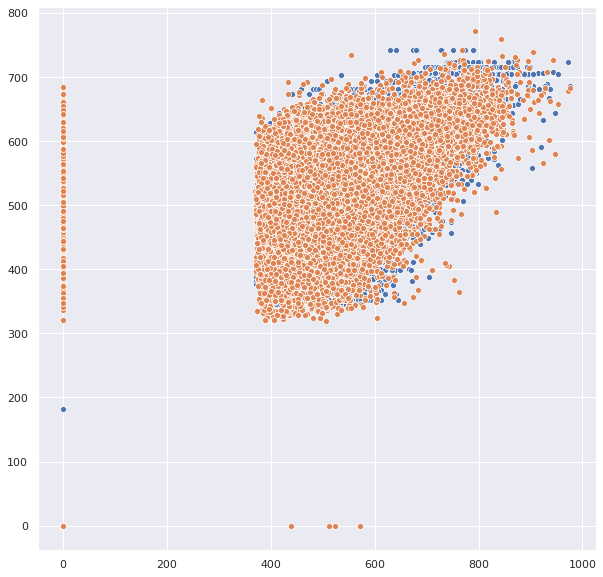

In [34]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=x_teste['matematica'].values, y=predicoes_media_arvore)
sns.scatterplot(x=x_teste['matematica'].values, y=y_teste.values)
plt.show()

Podemos observar que usar a média como entrada não foi uma ideia boa nessa regressão, isso porque o erro aumentou de forma significativa, sendo melhor usar os dados originais do que a média de todos os valores.

O próximo desafio era remover os 0's do conjunto inicial e observar como os regressores se comportam.

In [0]:
sem_0 = dados_notas[['ciencias_naturais', 'ciencias_humanas','matematica','redacao','linguagem_codigo']]

sem_0['ciencias_humanas'] = sem_0['ciencias_humanas'].replace(0,np.nan)
sem_0['ciencias_naturais'] = sem_0['ciencias_naturais'].replace(0,np.nan)
sem_0['linguagem_codigo'] = sem_0['linguagem_codigo'].replace(0,np.nan)
sem_0['matematica'] = sem_0['matematica'].replace(0,np.nan)
sem_0['redacao'] = sem_0['redacao'].replace(0,np.nan)

sem_0 = sem_0.dropna(subset=['ciencias_naturais', 'ciencias_humanas','matematica','redacao','linguagem_codigo'])

Agora vamos retreinar os modelos e aplicá-los.

In [0]:
x_0 = sem_0[['ciencias_naturais', 'ciencias_humanas','matematica','redacao']]
y_0 = sem_0['linguagem_codigo']

np.random.seed(30284)

x_treino_0, x_teste_0, y_treino_0, y_teste_0 = train_test_split(x_0,y_0)

In [37]:
modelo.fit(x_treino_0,y_treino_0)
modelo_arvore.fit(x_treino_0, y_treino_0)

predicoes_sem_0 = modelo.predict(x_teste_0)
predicoes_arvore_sem_0 = modelo_arvore.predict(x_teste_0)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [38]:
mean_squared_error(y_teste_0, predicoes_sem_0)

2344.19

In [39]:
mean_squared_error(y_teste_0, predicoes_arvore_sem_0)

4082.43

Interessante observar que o modelo linear piorou de forma significativa e o modelo de Regressão por Árvores de Decisão teve uma melhoria razoável. Isso pode indicar que o modelo linear usa melhor os 0's para fazer sua predição, já que com a remoção desses valores o Regressor passou a ser muito pior, enquanto a retirada de 0's fez apenas uma pequena melhora, indicando que esses valores não tem tanta participação.

O último desafio era treinar os modelos e usar os próprios dados para serem previstos e observar como o Regressor se comportava. 

In [40]:
modelo.fit(x_treino, y_treino)
modelo_arvore.fit(x_treino, y_treino)

predicoes_teste = modelo.predict(x_treino)
predicoes_arvore_teste = modelo_arvore.predict(x_treino)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [41]:
mean_squared_error(y_treino, predicoes_teste)

6929.58

In [42]:
mean_squared_error(y_treino, predicoes_arvore_teste)

45.03

O erro do Regressor Linear foi o maior até agora, enquanto o da Árvore de Decisão foi baixíssimo. Isso pode indicar que o modelo de Árvore de Decisão aprende muito mais com os dados de treinamento do que a regressão linear, já que acertou muito mais os casos que ele já tinha visto, enquanto o linear errou(e por muito) casos que já tinha visto.